In [2]:
%store -r  X
%store -r  y

%store -r  x_train
%store -r  x_test

%store -r  y_train
%store  -r y_test

%store -r col_trans
%store -r cat
%store -r scoring

## Random Forest Model 

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat), remainder='passthrough')

In [4]:
def eval (model, x_train, y_train,x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_pred = model.predict(x_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


opers = [("ord_enc", ord_enc), 
         ("rf_model", RandomForestClassifier(class_weight="balanced",random_state=101))]
pip_rf_model = Pipeline(steps=opers)

pip_rf_model.fit(x_train, y_train)

Pipeline(steps=[('ord_enc',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('rf_model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=101))])

In [7]:
eval(pip_rf_model, x_train, y_train, x_test, y_test)

Test_Set
[[176   2  82]
 [  8   3 125]
 [  9   2 747]]
              precision    recall  f1-score   support

       Black       0.91      0.68      0.78       260
    Hispanic       0.43      0.02      0.04       136
       White       0.78      0.99      0.87       758

    accuracy                           0.80      1154
   macro avg       0.71      0.56      0.56      1154
weighted avg       0.77      0.80      0.75      1154


Train_Set
[[1038    0    0]
 [   0  543    0]
 [   0    0 3034]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00      1038
    Hispanic       1.00      1.00      1.00       543
       White       1.00      1.00      1.00      3034

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [8]:
import pandas as pd
from sklearn.model_selection import cross_validate


operations_rf = [
    ("OrdinalEncoder", column_trans),
    ("rf_model", RandomForestClassifier(class_weight="balanced", random_state=101)),
]

model = Pipeline(steps=operations_rf)

scores = cross_validate(
    model, x_train, y_train, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True
)
df_scores = pd.DataFrame(scores, index=range(1, 6))
df_scores.mean()[2:]

test_precision_Hispanic     0.741667
train_precision_Hispanic    1.000000
test_f1_Hispanic            0.079890
train_f1_Hispanic           1.000000
test_recall_Hispanic        0.042355
train_recall_Hispanic       1.000000
dtype: float64

In [9]:
## RF Gridsearch >>

## RF Gridsearch >>


In [10]:
params = {
    "rf_model__n_estimators": [400, 500],
    "rf_model__max_depth": [2, 3],
    # 'RF_model__min_samples_split':[18,20,22],
    # 'RF_model__max_features': ['auto', None, 15, 20]
}

In [14]:
from sklearn.metrics import make_scorer, recall_score


recall_Hispanic = make_scorer(recall_score, average=None, labels=["Hispanic"])


In [15]:
from sklearn.model_selection import GridSearchCV

ops = [("OrdinalEncoder", column_trans),
       ("rf_model", RandomForestClassifier(class_weight='balanced',random_state=101))]

model = Pipeline(steps=ops)



rf_grid_model = GridSearchCV(model, 
                            params, 
                            scoring=recall_Hispanic, 
                            n_jobs=-1, 
                            return_train_score=True)


In [16]:
rf_grid_model.fit(x_train, y_train)

#the name of params should match with pipline name

GridSearchCV(estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Gender', 'WritingPreference'], dtype='object'))])),
                                       ('rf_model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'rf_model__max_depth': [2, 3],
                         'rf_model__n_estimators': [400, 500]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [17]:
rf_grid_model.best_estimator_

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Gender', 'WritingPreference'], dtype='object'))])),
                ('rf_model',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        n_estimators=500, random_state=101))])

In [18]:
rf_grid_model.best_params_

{'rf_model__max_depth': 2, 'rf_model__n_estimators': 500}

In [21]:
res=pd.DataFrame(rf_grid_model.cv_results_)[["mean_test_score", "mean_train_score"]]
res

,mean_test_score,mean_train_score
0,0.600272,0.647800
1,0.605793,0.647800
2,0.600272,0.658852
3,0.602124,0.659309


In [23]:
pd.DataFrame(rf_grid_model.cv_results_).loc[
    rf_grid_model.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.605793
mean_train_score      0.6478
Name: 1, dtype: object

In [24]:
eval(rf_grid_model, x_train, y_train, x_test, y_test)

Test_Set
[[179  60  21]
 [ 12  87  37]
 [ 62 310 386]]
              precision    recall  f1-score   support

       Black       0.71      0.69      0.70       260
    Hispanic       0.19      0.64      0.29       136
       White       0.87      0.51      0.64       758

    accuracy                           0.56      1154
   macro avg       0.59      0.61      0.54      1154
weighted avg       0.75      0.56      0.61      1154


Train_Set
[[ 724  201  113]
 [  47  349  147]
 [ 240 1113 1681]]
              precision    recall  f1-score   support

       Black       0.72      0.70      0.71      1038
    Hispanic       0.21      0.64      0.32       543
       White       0.87      0.55      0.68      3034

    accuracy                           0.60      4615
   macro avg       0.60      0.63      0.57      4615
weighted avg       0.76      0.60      0.64      4615



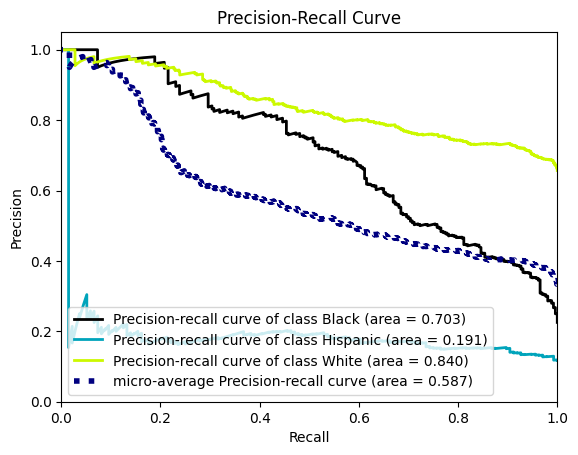

In [27]:
from matplotlib import pyplot as plt
from scikitplot.metrics import plot_roc, plot_precision_recall


ops = [("OrdinalEncoder", column_trans),
       ("rf_model", RandomForestClassifier(max_depth=1,n_estimators=400,class_weight='balanced',random_state=101))]

model = Pipeline(steps=ops)

model.fit(x_train, y_train)

y_pred_proba = model.predict_proba(x_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [28]:
# we can't use the average_precision_score function with the y_test variable because it's not a binary
from sklearn.metrics import average_precision_score

y_test_dummies = pd.get_dummies(y_test).values  # we do that for the sake of the average_precision_score function.

average_precision_score(y_test_dummies[:, 1], y_pred_proba[:, 1])

# Returns 0 black, 1 hispanic, 2 white scores.
# We got hispanic scores by specifying 1 here.

0.19079950131398166

In [32]:
average_precision_score(y_test_dummies[:, 1], y_pred_proba[:, 1])

0.19079950131398166

In [31]:
from sklearn.metrics import f1_score


y_pred = rf_grid_model.predict(x_test)

rf_AP = average_precision_score(y_test_dummies[:, 1], y_pred_proba[:, 1])
rf_f1 = f1_score(y_test, y_pred, average=None, labels=["Hispanic"])
rf_recall = recall_score(y_test, y_pred, average=None, labels=["Hispanic"])

In [33]:
%store rf_recall 
%store rf_AP
%store rf_f1

Stored 'rf_recall' (ndarray)
Stored 'rf_AP' (float64)
Stored 'rf_f1' (ndarray)
